#### Summary: 
In this notebook we identify genes, cREs and motifs with cell type-specific expression, accessibility, or motif accessibility, respectively. We first create per cell type- normalized pseudobulk counts matrices and then use Shannon's Entropy to find genes and cREs that are specific to one cell type. Then we find motifs enriched in cell type specific cREs with homer and perform correlation between motif accesssibility (from ChromVAR) and gene expression to identify active TFs. Because the last part requires ChromVAR outputs, you'll need to run the first ChromVAR notebook before running that. 

Required inputs:
- Matrix of per-cell type pseudobulk TPM values (RNA)
- Matrix of per-cell type pseudobulk CPM values (ATAC)
- List of all peaks accessible in each cell type (to use as background for HOMER)
- Per-donor cell type TPM matrix
- Per-donor cell type average ChromVAR devscore matrix

In [1]:
suppressMessages(library(hdf5r))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))

suppressMessages(library(dplyr))
suppressMessages(library(stringr))
suppressMessages(library(data.table))
suppressMessages(library(tictoc))

In [1]:
suppressMessages(library('DescTools'))

In [3]:
rna_celltypes <- c('beta','alpha','delta','acinar','ductal','stellate','immune')
atac_celltypes <- c('beta','alpha','delta','gamma','acinar','ductal')
joint_celltypes <- c('beta', 'alpha', 'delta', 'gamma', 'acinar','ductal', 'endothelial', 'immune','stellate')

In [4]:
alberta_samples <- c('R207','R217','R218','R221','R223',
                      'R226','R228','R234','R237','R238',
                      'R246', 'R247', 'R275', 'R284', 
                      'R290', 'R292', 'R316', 'R317', 'R319',
                      'R325','R326','R327','R332',
                      'R353','R354','R362','R363','R364')

## Input files

In [5]:
prev_rna_dir <- '/dir/with/cell/type/TPM/matrix'
prev_atac_dir <- '/dir/with/cell/type/CPM/matrix'
outdir <- '/place/to/save/entropy_outputs'

In [ ]:
atac_ct_peaks_dir <- '/dir/with/cell/type/peaks/beds'

In [167]:
#directories for inputs
tpm_dir <- '/path/to/per/donor/tpm/matrices'
motif_dir <- '/path/to/per/donor/avg/motif/devscores'

In [8]:
#motif family maps
lookup_fp <- 'non-diabetic-islet-multiomics/references/220907_WE_Chromvar_to_Gene_By_Subfam_Complete(JAPRAR2022_TFClass).csv'

# Find cell type-specific genes

In [51]:
#read in the all cell types CPM matrix
mtx_fp <- file.path(prev_rna_dir,'major_celltype_TPM_values.txt')
tpm <- read.table(mtx_fp, sep='\t', header=1)
tpm <- tpm[,joint_celltypes]
head(tpm)

#remove any genes not expressed in any cell type
not_expressed <- row.names(tpm[rowSums(tpm)==0,])
length(not_expressed)
tpm_fin <- tpm[rowSums(tpm)>0,]

,beta,alpha,delta,gamma,acinar,ductal,endothelial,immune,stellate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TSPAN6,2.792134e-01,1.248374,1.046538,1.466022,1.4362978,2.495515,5.84893,0.000000,1.457858
TNMD,8.964312e-03,0.000000,0.000000,0.000000,0.0000000,0.000000,0.00000,0.000000,0.000000
DPM1,5.989624e+02,454.651649,522.208820,634.440533,1093.3209236,286.313021,481.25220,350.184105,380.589776
SCYL3,7.442227e+00,6.978980,9.241753,10.661821,6.8632041,7.634989,12.74722,5.253001,10.653084
C1orf112,7.810353e+00,10.512773,13.304809,8.727198,4.7928538,24.511730,13.28311,2.008828,9.374402
FGR,2.065146e+00,2.966342,2.416901,2.175784,0.6314084,4.657305,21.66379,80.794243,3.914960


[1] 1830

In [52]:
#convert TPM values to prob values (based on rowSums)
probs <- list()
rowsums <- rowSums(tpm_fin)

for(celltype in joint_celltypes){
    probs[[celltype]] <- tpm_fin[,celltype]/rowsums
}

prob_df <- as.data.frame(probs)
head(prob_df)

,beta,alpha,delta,gamma,acinar,ductal,endothelial,immune,stellate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TSPAN6,0.01827463,0.08170657,0.06849630,0.09595168,0.094006252,0.16333243,0.3828148,0.00000000,0.09541736
TNMD,1.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.0000000,0.00000000,0.00000000
DPM1,0.12473385,0.09468115,0.10874993,0.13212217,0.227683957,0.05962465,0.1002207,0.07292580,0.07925778
SCYL3,0.09605814,0.09007893,0.11928494,0.13761400,0.088584587,0.09854615,0.1645306,0.06780142,0.13750124
C1orf112,0.08280165,0.11145142,0.14105126,0.09252160,0.050811557,0.25986170,0.1408212,0.02129664,0.09938295
FGR,0.01702710,0.02445744,0.01992731,0.01793930,0.005205951,0.03839940,0.1786176,0.66614712,0.03227878


[1] 3.167868

[1] 0

[1] 3.169925


FALSE  TRUE 
25113  9648 

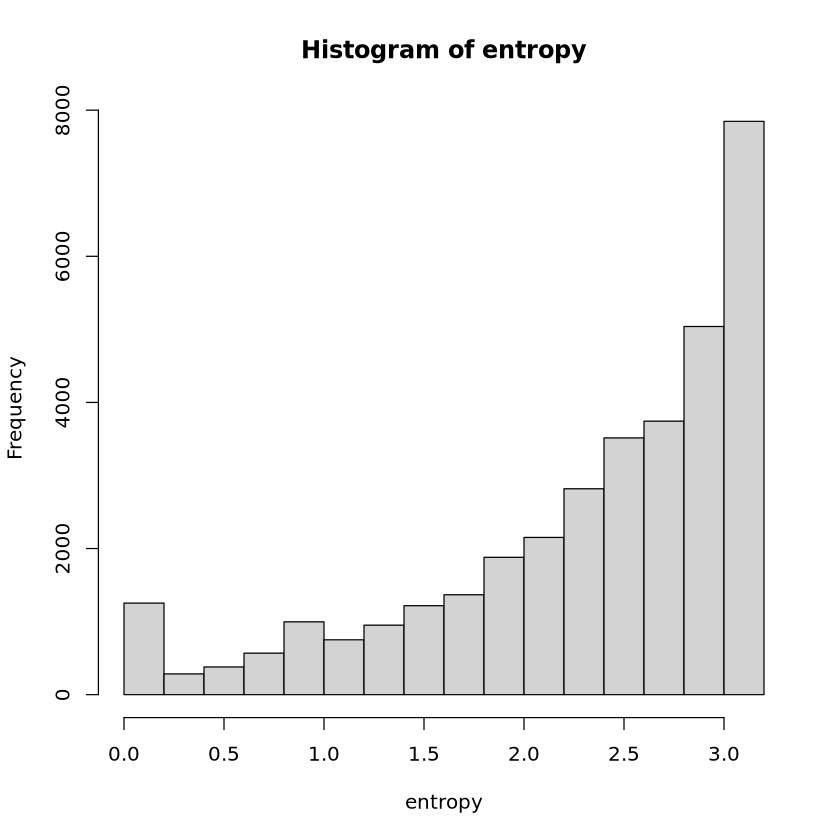

In [54]:
#calculate entropy with DescTools::Entropy function
entropy <- apply(prob_df, 1, Entropy)
hist(entropy)
max(entropy)
min(entropy)
log2(9)

entropy_cutoff <- 2
table(entropy < entropy_cutoff)

In [ ]:
#add entropy into the TPM df and save to file
ent_df <- copy(tpm_fin)
ent_df$entropy <- entropy
ent_df <- ent_df %>% arrange(entropy)

fp <- file.path(outdir,'RNA_TPM_all_ct_probs_entropy.txt')
write.table(ent_df, fp, sep='\t', quote=F)

In [58]:
#manipulate df before extracting cell type-specific genes
ent_df <- ent_df %>% tibble::rownames_to_column(var='gene') %>%
        group_by(gene) %>%
        mutate(max_prob=max(beta,alpha,delta,gamma,acinar,ductal,endothelial,immune,stellate)) 
max_prob <- ent_df$max_prob
head(ent_df)

gene,beta,alpha,delta,gamma,acinar,ductal,endothelial,immune,stellate,entropy,max_prob
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TNMD,0.008964312,0.00000000,0,0.000000,0,0,0,0.000000,0,0,0.008964312
HOXA11,0.005735295,0.00000000,0,0.000000,0,0,0,0.000000,0,0,0.005735295
GUCA1A,0.000000000,0.03057408,0,0.000000,0,0,0,0.000000,0,0,0.030574076
NME8,0.000000000,0.00000000,0,0.000000,0,0,0,1.307914,0,0,1.307913736
HBQ1,0.000000000,0.00000000,0,0.464607,0,0,0,0.000000,0,0,0.464606953
CTSG,0.000000000,0.02193601,0,0.000000,0,0,0,0.000000,0,0,0.021936005


In [ ]:
entropy_cutoff <- 2

for(celltype in joint_celltypes){
    ct_genes <- ent_df[which(ent_df[,celltype]==max_prob & ent_df$entropy < entropy_cutoff),]$gene
    gene_entropy <- ent_df[which(ent_df[,celltype]==max_prob & ent_df$entropy < entropy_cutoff),]$entropy
    ct_tpm <- tpm[ct_genes,celltype]
    ct_genes_df <- data.frame(gene=ct_genes, entropy=gene_entropy, ct_tpm=ct_tpm)

    #also filter for CPM > 1
    out_fp <- file.path(outdir,'RNA_ct_spec_genes',sprintf('%s_entropy2_genes_TPM1.txt',celltype))
    write.table(subset(ct_genes_df,ct_tpm>=1) %>% arrange(-ct_tpm), out_fp, row.names=F, quote=F)
}

# Find cell type-specific accessible cREs

In [66]:
#read in the all cell types CPM matrix
mtx_fp <- file.path(prev_atac_dir,'all_celltypes_UNION_peak_CPM.txt')
cpm <- read.table(mtx_fp, sep='\t', header=1)
head(cpm)

,beta,alpha,delta,gamma,acinar,ductal,endothelial,immune,stellate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1-1000073-1000373,10.5893770,16.4472833,12.1852990,18.0613641,17.4654329,37.2103811,38.5004091,18.426905,39.5686054
chr1-100036794-100037094,2.1424088,2.9736072,2.5644981,3.3451681,8.6527831,6.2230054,4.8125511,3.071151,3.4727765
chr1-100037929-100038229,32.6932427,32.3645557,35.5804438,33.7696632,37.2222880,35.7902594,35.1686429,39.583723,31.7811671
chr1-100046138-100046438,0.6797782,0.6794615,0.7866558,0.5596479,0.5328889,0.5106056,0.0000000,3.071151,0.2104713
chr1-100046907-100047207,0.7726301,0.8920822,0.6765240,1.0556995,0.5795167,1.5158603,0.3701962,1.706195,0.3157070
chr1-100050188-100050403,0.7871116,0.5484996,0.7237234,0.5596479,0.2797667,0.2233899,0.0000000,0.000000,0.1052357


In [67]:
#convert CPM values to prob values (based on rowSums)
probs <- list()
rowsums <- rowSums(cpm)

for(celltype in joint_celltypes){
    probs[[celltype]] <- cpm[,celltype]/rowsums
}

prob_df <- as.data.frame(probs)
head(prob_df)

,beta,alpha,delta,gamma,acinar,ductal,endothelial,immune,stellate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1-1000073-1000373,0.05079933,0.07890086,0.05845528,0.08664392,0.08378512,0.17850553,0.18469405,0.08839750,0.18981840
chr1-100036794-100037094,0.05750206,0.07981135,0.06883090,0.08978401,0.23223992,0.16702490,0.12916844,0.08242941,0.09320901
chr1-100037929-100038229,0.10413387,0.10308694,0.11333012,0.10756246,0.11855969,0.11399842,0.11201846,0.12608129,0.10122874
chr1-100046138-100046438,0.09668768,0.09664264,0.11188933,0.07960105,0.07579500,0.07262555,0.00000000,0.43682255,0.02993621
chr1-100046907-100047207,0.09799465,0.11314506,0.08580527,0.13389706,0.07350158,0.19226044,0.04695294,0.21640107,0.04004192
chr1-100050188-100050403,0.24388603,0.16995224,0.22424523,0.17340655,0.08668552,0.06921723,0.00000000,0.00000000,0.03260720


[1] 3.169421

[1] 0.2472489

[1] 3.169925


 FALSE   TRUE 
263402  28419 

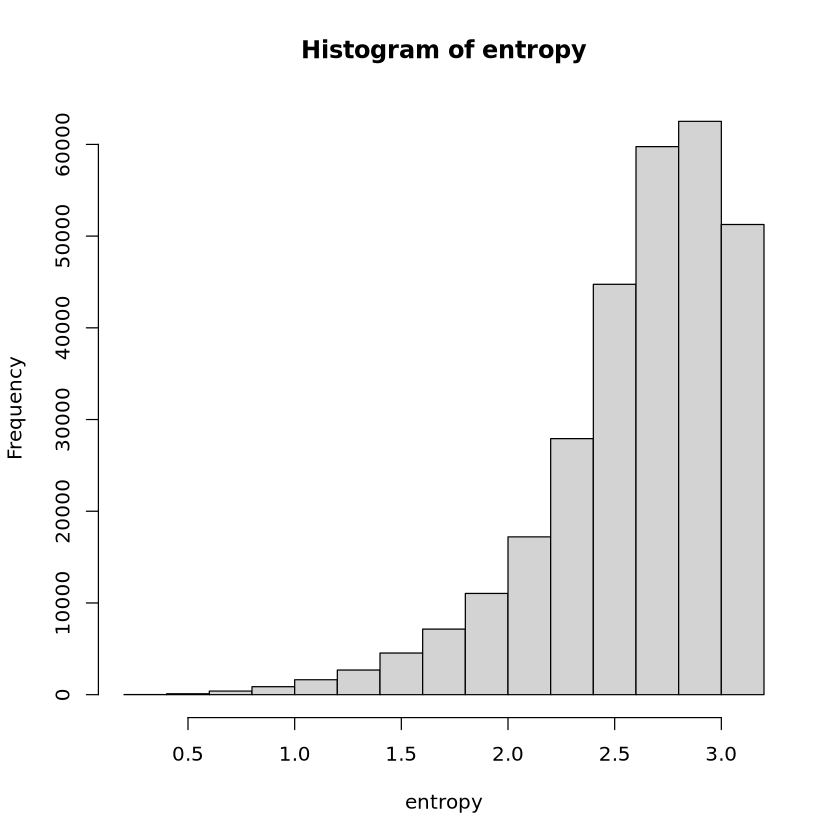

In [68]:
#calculate entropy with DescTools::Entropy function
entropy <- apply(prob_df, 1, Entropy)
hist(entropy)
max(entropy)
min(entropy)
log2(9)

entropy_cutoff <- 2
table(entropy < entropy_cutoff)

In [ ]:
#add entropy into the CPM df and save to file
ent_df <- copy(prob_df)
ent_df$entropy <- entropy
ent_df <- ent_df %>% arrange(entropy)

fp <- file.path(outdir,'ATAC_UNION_PEAKS_CPM_all_ct_probs_entropy.txt')
write.table(ent_df, fp, sep='\t', quote=F)

In [70]:
#manipulate df before extracting cell type-specific peaks
ent_df <- ent_df %>% tibble::rownames_to_column(var='cre') %>%
        group_by(cre) %>%
        mutate(max_prob=max(beta,alpha,delta,gamma,acinar,ductal,endothelial,immune,stellate)) 
max_prob <- ent_df$max_prob
head(ent_df)

cre,beta,alpha,delta,gamma,acinar,ductal,endothelial,immune,stellate,entropy,max_prob
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr5-69596325-69596524,0.007754572,0.008765966,0.008951345,0.000000000,0.003789834,0.000000000,0.0000000,0.9707383,0.000000000,0.2472489,0.9707383
chr15-39397004-39397304,0.005686707,0.005366315,0.001826600,0.005906781,0.005026766,0.005557577,0.0000000,0.9706293,0.000000000,0.2649941,0.9706293
chrX-1239732-1240032,0.005920107,0.006743326,0.003964627,0.008434632,0.004770615,0.003386020,0.0000000,0.9639892,0.002791431,0.3214528,0.9639892
chr4-128916881-128917181,0.011673875,0.008779109,0.006808683,0.005504407,0.005044673,0.002301774,0.0000000,0.9598875,0.000000000,0.3406128,0.9598875
chr2-71492140-71492440,0.007533661,0.008054473,0.005565658,0.007499161,0.004712793,0.006271837,0.9603624,0.0000000,0.000000000,0.3421298,0.9603624
chr19-54607017-54607317,0.009086266,0.006660158,0.008390849,0.007140518,0.007292036,0.003583134,0.0000000,0.9578470,0.000000000,0.3589546,0.9578470


In [71]:
entropy_cutoff <- 2

for(celltype in joint_celltypes){
    ct_peaks <- ent_df[which(ent_df[,celltype]==max_prob & ent_df$entropy < entropy_cutoff),]$cre
    peak_entropy <- ent_df[which(ent_df[,celltype]==max_prob & ent_df$entropy < entropy_cutoff),]$entropy
    ct_cpm <- cpm[ct_peaks,celltype]
    ct_peaks_df <- data.frame(peak=ct_peaks, entropy=peak_entropy, ct_cpm=ct_cpm)

    #also filter for CPM > 5
    out_fp <- file.path(outdir,'ATAC_ct_spec_cREs',sprintf('%s_entropy2_UNION_cREs_CPM5.txt',celltype))
    write.table(subset(ct_peaks_df,ct_cpm>=5) %>% arrange(-ct_cpm), out_fp, row.names=F, quote=F)
}

                       peak   entropy   ct_cpm
1  chr2-185705081-185705372 0.7300637 1.039260
2    chr2-77450066-77450366 1.0811692 1.741186
3 chr10-120173974-120174274 1.1651095 3.056446
4  chr5-156561453-156561753 1.1794913 3.277076
5 chr10-131163200-131163500 1.1820711 5.977448
6   chr22-34614292-34614592 1.2864244 1.997594
                      peak  entropy    ct_cpm
1   chrX-56833718-56834012 1.021953  1.642417
2 chr9-120005219-120005519 1.044550 13.675512
3   chrX-32807894-32808184 1.071386  1.130895
4     chr8-2946000-2946300 1.160333  2.805668
5  chr20-56326750-56327050 1.212782  6.031954
6  chr10-24177671-24177955 1.214171  2.193998
                       peak   entropy   ct_cpm
1  chr3-103325978-103326278 0.6403994 5.545924
2 chr11-121991470-121991770 0.9986194 1.581178
3   chr18-36561213-36561513 1.0571681 5.349260
4    chr6-64473363-64473663 1.0641459 2.352101
5   chr15-96598604-96598904 1.0736357 1.636244
6    chr2-15664714-15665014 1.0802340 7.134969
                    

# Find cell type-specific TF motifs

## Run HOMER on cell type-specific peaks
This code writes all HOMER commands to a script and then you can run that in the terminal, either in parallel, in a screen, or both. To run this you'll need to have HOMER downloaded and installed somewhere on your computer or server. This will take an input of a file path to the HOMER install and then will run the `findMotifsGenome.pl` command in `homer/bin`.

In [94]:
### Function to run HOMER on a set of peaks
run_HOMER <- function(celltype, indir, homer_dir, homer_install_fp, script_fp){
    #check if there are enough sig results for the association in the great_dir
    bed_fp <- file.path(indir, sprintf('%s_entropy2_UNION_cREs_CPM5.bed',celltype))
    
    if(file.exists(bed_fp)){
        #set up homer code
        bg_fp <- file.path(homer_dir, 'all_ct_peaks', sprintf('%s_union_peaks.bed',celltype)) 
        log_fp <- file.path(homer_dir, 'log_HOMER.txt')
        cmd <- sprintf('perl %s/bin/findMotifsGenome.pl %s hg38 %s -bg %s -size 200 -p 20 -bits > %s', homer_install_fp, bed_fp, file.path(homer_dir,celltype), bg_fp, log_fp)
        write(cmd, script_fp, append=TRUE)
    }
}

In [ ]:
homer_dir <- file.path(outdir,'HOMER_ATAC_ct_spec_cREs')
dir.create(file.path(homer_dir,'ct_spec_peaks'), showWarnings = FALSE, recursive = TRUE)
script_fp <- file.path(homer_dir,'HOMER_commands.sh') #in terminal: touch fp and add shebang first!!!
homer_install_fp <- '/home/hmummey/homer'

for(celltype in joint_celltypes){
    #read in peak results and write to bed file
    fp <- file.path(outdir,'ATAC_ct_spec_cREs',sprintf('%s_entropy2_UNION_cREs_CPM5.txt',celltype))
    df <- read.table(fp, sep='\t', header=1)
    bed <- str_split_fixed(df$peak, '-', 3)
    out_fp <- file.path(homer_dir,'ct_spec_peaks',sprintf('%s_entropy2_UNION_cREs_CPM5.bed',celltype))
    write.table(bed, out_fp, sep='\t', row.names=F, col.names=F, quote=F)

    #also softlink all cell type accessible peaks to the homer dir
    fp1 <- file.path(atac_ct_peaks_dir,sprintf('%s.peaks.bed',celltype))
    fp2 <- file.path(homer_dir,'all_ct_peaks',sprintf('%s_union_peaks.bed',celltype))
    cmd <- sprintf('ln -s %s %s', fp1, fp2)
    system(cmd)

    #now run homer equation to write script
    dir.create(file.path(homer_dir,celltype), showWarnings = FALSE)
    run_HOMER(celltype, file.path(homer_dir,'ct_spec_peaks'), homer_dir, homer_install_fp, script_fp)
}

## Correlate motif accessibility with expression

In [122]:
### Function to run correlation test and return results 
cortest_motif_gene <- function(motif, gene, motif_df, tpm_df){
    res <- cor.test(unlist(motif_df[motif,]), unlist(tpm_df[gene,]),alternative='two.sided', method='spearman')
    avg_gex <- rowMeans(tpm_df[gene,])
    results_vector <- c(res$estimate,res$p.value,avg_gex)
    return(results_vector)
}

In [168]:
#Search JASPAR motifs for those that match a shortened homer motif
get_motif_matches <- function(homer_motif, jaspar_motifs){
    motifs <- jaspar_motifs[grepl(str_to_upper(homer_motif),jaspar_motifs)]
    if(length(motifs) > 0) {
        return(paste(motifs,collapse=','))
    } else {
        return(NA)
    }
}

In [203]:
### Big wrapper function to read in entropy cRE homer results, map to jaspar motifs and genes,
### then correlate gene expression with motif accessibility (by donor) and save out results
motif_gene_cortest_wrapper <- function(celltype, outdir){
    #read in per-donor tpm and devscore files
    tpm_fp <- file.path(tpm_dir,sprintf('%s_sample_gex_TPM.txt',celltype))
    tpm_df <- read.table(tpm_fp, sep='\t')
    motif_fp <- file.path(motif_dir,sprintf('%s_Alberta_donor_devscores_ChromVAR_fin.txt',celltype))
    motif_df <- read.table(motif_fp, sep='\t')

    #read in the homer motif results and clean up a lot
    homer_fp <- file.path(homer_dir,celltype,'knownResults.txt')
    homer <- fread(homer_fp)
    colnames(homer) <- c('motif','consensus','pval','log_pval','qval','target_seq_w_motif','perc_target_seq_w_motif','bg_seq_w_motif','perc_bg_seq_w_motif')    
    homer$perc_target_seq_w_motif <- gsub("[%]", "", homer$perc_target_seq_w_motif) #remove percents
    homer$perc_bg_seq_w_motif <- gsub("[%]", "", homer$perc_bg_seq_w_motif)
    homer <- homer %>% select(-c(consensus,target_seq_w_motif,bg_seq_w_motif)) %>%
                mutate(motif_short=gsub("/.*",'',motif)) %>% mutate(motif_short=gsub("[(].*", "", motif_short)) %>% #shorten motif names to TFs
                mutate_at(c('perc_target_seq_w_motif','perc_bg_seq_w_motif'),as.numeric) %>% #convert percents to numeric
                mutate(fc=(perc_target_seq_w_motif-perc_bg_seq_w_motif)/perc_bg_seq_w_motif) #calculate foldchange
    homer$padj <- p.adjust(homer$pval,method='BH')

    #map sig homer motifs to JASPAR motifs
    homer_sig <- subset(homer, padj < 0.1)
    matches <- lapply(homer_sig$motif_short, get_motif_matches, row.names(motif_df))
    match_df <- data.frame(motif_short=homer_sig$motif_short, motif_jaspar=unlist(matches)) %>%
                    tidyr::separate_rows(motif_jaspar, sep=',')
    homer_fin <- left_join(homer_sig, match_df, by='motif_short')

    #now map in all family member genes from motif_map
    jaspar_motifs <- unique(subset(homer_fin, motif_jaspar!='') %>% pull(motif_jaspar))
    gene_map <- subset(motif_map, full_jaspar_motif %in% jaspar_motifs) %>%
                    select(full_jaspar_motif,gene) %>%
                    rename(motif_jaspar=full_jaspar_motif)
    homer_fin2 <- as.data.frame(left_join(homer_fin, gene_map, by='motif_jaspar'))
        
    #run cor.test on all motif and gene pairs, save to df
    results_df <- data.frame()
    for(row in seq(dim(homer_fin2)[1])){
        motif <- unlist(homer_fin2[row,'motif_jaspar'])
        gene <- unlist(homer_fin2[row,'gene'])
        if((gene %in% row.names(tpm_df) & (motif %in% row.names(motif_df)))){
            cor_res <- suppressWarnings(cortest_motif_gene(motif, gene, motif_df, tpm_df))
            results <- c(cor_res, motif, gene)
            results_df <- rbind(results_df,results)
        }
    }
    colnames(results_df) <- c('cor_estimate','cor_pvalue','avg_TPM','motif_jaspar','gene')
    results <- left_join(homer_fin2, results_df, by=c('motif_jaspar','gene'))
    results$cor_padj <- p.adjust(results$cor_pvalue, method='BH')
    
    #write results to a file
    fp <- file.path(outdir,sprintf('%s_sig_avg_TPM1_pos_corr_entropy_cRE_HOMER_motif_gene_corrs.txt',celltype))
    write.table(subset(results, avg_TPM > 1 & cor_padj < 0.1 & cor_estimate > 0), fp, sep='\t', row.names=FALSE, quote=FALSE)
}

In [9]:
#read in motif family map and reformat a bit
motif_map <- read.table(lookup_fp, sep=',', header=1)
head(motif_map)

,full_jaspar_motif,jaspar_motif,lowest_level_family,gene
,<chr>,<chr>,<chr>,<chr>
1,MA0030.1_FOXF2,FOXF2,FOXF,FOXF2
2,MA0030.1_FOXF2,FOXF2,FOXF,FOXF1
3,MA0031.1_FOXD1,FOXD1,FOXD,FOXD1
4,MA0031.1_FOXD1,FOXD1,FOXD,FOXD2
5,MA0031.1_FOXD1,FOXD1,FOXD,FOXD3
6,MA0031.1_FOXD1,FOXD1,FOXD,FOXD4L1


In [204]:
motif_corr_outdir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/entropy_outputs/HOMER_ATAC_ct_spec_cREs/motif_gene_corrs'
for(celltype in celltypes){
    motif_gene_cortest_wrapper(celltype,motif_corr_outdir)
}